In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import decode_static

In [2]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'

load neural data

In [3]:
unsorted_trials, stim_on_times, np1_channel_map = data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=True
)

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.8056523600408,                 last trial stim on time 2252.103067172252


In [4]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

In [5]:
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

load behavior data

In [6]:
behave_dict = data_preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


thresholded decoding

In [7]:
thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 384, 30)


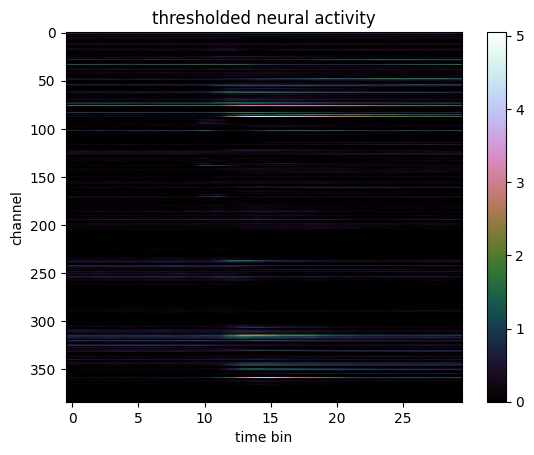

In [8]:
plt.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('thresholded neural activity')
plt.xlabel('time bin')
plt.ylabel('channel')
plt.colorbar();

In [9]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(thresholded_neural_data, choices, behave_type='choice', n_folds=10, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(thresholded_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=10, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 0.992
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 1.000 auc: 1.000
choice fold 5 test accuracy: 0.913 auc: 0.992
choice fold 6 test accuracy: 0.957 auc: 1.000
choice fold 7 test accuracy: 0.913 auc: 0.967
choice fold 8 test accuracy: 0.957 auc: 1.000
choice fold 9 test accuracy: 0.913 auc: 0.984
choice fold 10 test accuracy: 1.000 auc: 1.000
choice mean of 10-fold cv accuracy: 0.961 auc: 0.993
choice sd of 10-fold cv accuracy: 0.036 auc: 0.010
stimulus fold 1 test accuracy: 0.348 auc: 0.809
stimulus fold 2 test accuracy: 0.391 auc: 0.746
stimulus fold 3 test accuracy: 0.435 auc: 0.864
stimulus fold 4 test accuracy: 0.478 auc: 0.867
stimulus fold 5 test accuracy: 0.478 auc: 0.896
stimulus fold 6 test accuracy: 0.478 auc: 0.820
stimulus fold 7 test accuracy: 0.435 auc: 0.841
stimulus fold 8 test accuracy: 0.391 auc: 0.842
stimulus fold 9 test accuracy: 0.391 auc: 0.850
sti

clusterless decoding

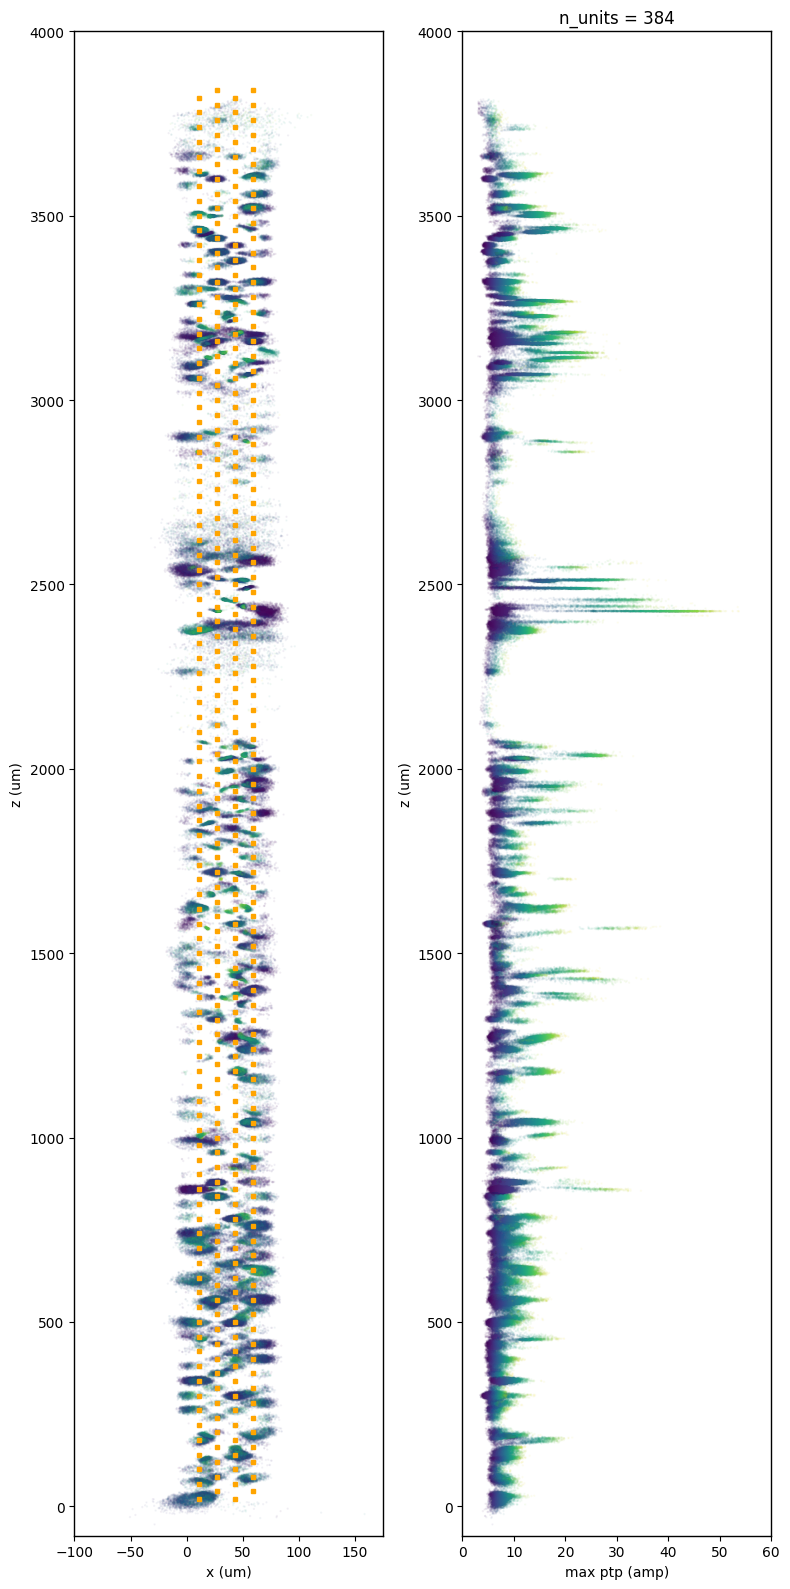

In [10]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=np.arange(n_channels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
)

model selection

In [ ]:
sample_spikes = [trial[np.random.choice(len(trial), 500), 2:] for trial in unsorted_trials]
sample_spikes = np.vstack(sample_spikes)
print(sample_spikes.shape)

In [ ]:
lowest_bic = np.infty
bic = []
k_range = range(300, 600, 50)

for k in k_range:
    print(f'--- fit MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=0, 
        # verbose_interval=10
    )
    gmm.fit(sample_spikes)
    bic.append(gmm.bic(sample_spikes))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current bic: {round(bic[-1],2)}')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

In [30]:
best_bic_gmm = GaussianMixture(
        init_params='kmeans',
        n_components=450, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=1, 
        verbose_interval=1
    ).fit(spike_features)

Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
  Iteration 20
  Iteration 21
  Iteration 22
  Iteration 23
Initialization converged: True


In [ ]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(i*offset, (i+1)*offset)
    spike_labels.extend(best_bic_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(best_bic_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

In [ ]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='best bic MoG'
)

In [ ]:
clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

In [ ]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [ ]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=10, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=10, seed=seed, shuffle=True)

distributed MoG using max channel (split-merge)

In [11]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    sub_x, sub_z, sub_maxptp = sub_spike_features.T
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        n_modes_x = len(UniDip(sub_x).run())
        n_modes_z = len(UniDip(sub_z).run())
        n_modes_ptp = len(UniDip(sub_maxptp).run())
        n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 38.0 has 4 modes ...
channel 39.0 has 2 modes ...
channel 45.0 has 2 modes ...
channel 62.0 has 5 modes ...
channel 66.0 has 4 modes ...
channel 71.0 has 2 modes ...
channel 72.0 has 3 modes ...
channel 73.0 has 2 modes ...
channel 78.0 has 3 modes ...
channel 84.0 has 2 modes ...
channel 85.0 has 5 modes ...
channel 86.0 has 3 modes ...
channel 88.0 has 2 modes ...
channel 89.0 has 2 modes ...
channel 91.0 has 4 modes ...
channel 99.0 has 2 modes ...
channel 101.0 has 2 modes ...
channel 116.0 has 5 modes ...
channel 124.0 has 6 modes ...
channel 126.0 has 3 modes ...
channel 128.0 has 2 modes ...
channel 132.0 has 2 modes ...
channel 134.0 has 3 modes ...
channel 136.0 has 2 modes ...
channel 138.0 has 2 modes ...
channel 139.0 has 2 modes ...
channel 140.0 has 5 modes ...
channel 141.0 has 2 modes ...
channel 142.0 has 6 modes ...
channel 143.0 has 3 modes ...
channel 144.0 has 2 modes ...
channel 145.0 has 3 modes ...
channel 154.0 has 2 modes ...
channel 155.0 has 2 modes 

In [12]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [13]:
len(spike_features)

438600

In [14]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(i*offset, (i+1)*offset)
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

0 100000
100000 200000
200000 300000
300000 400000
400000 500000


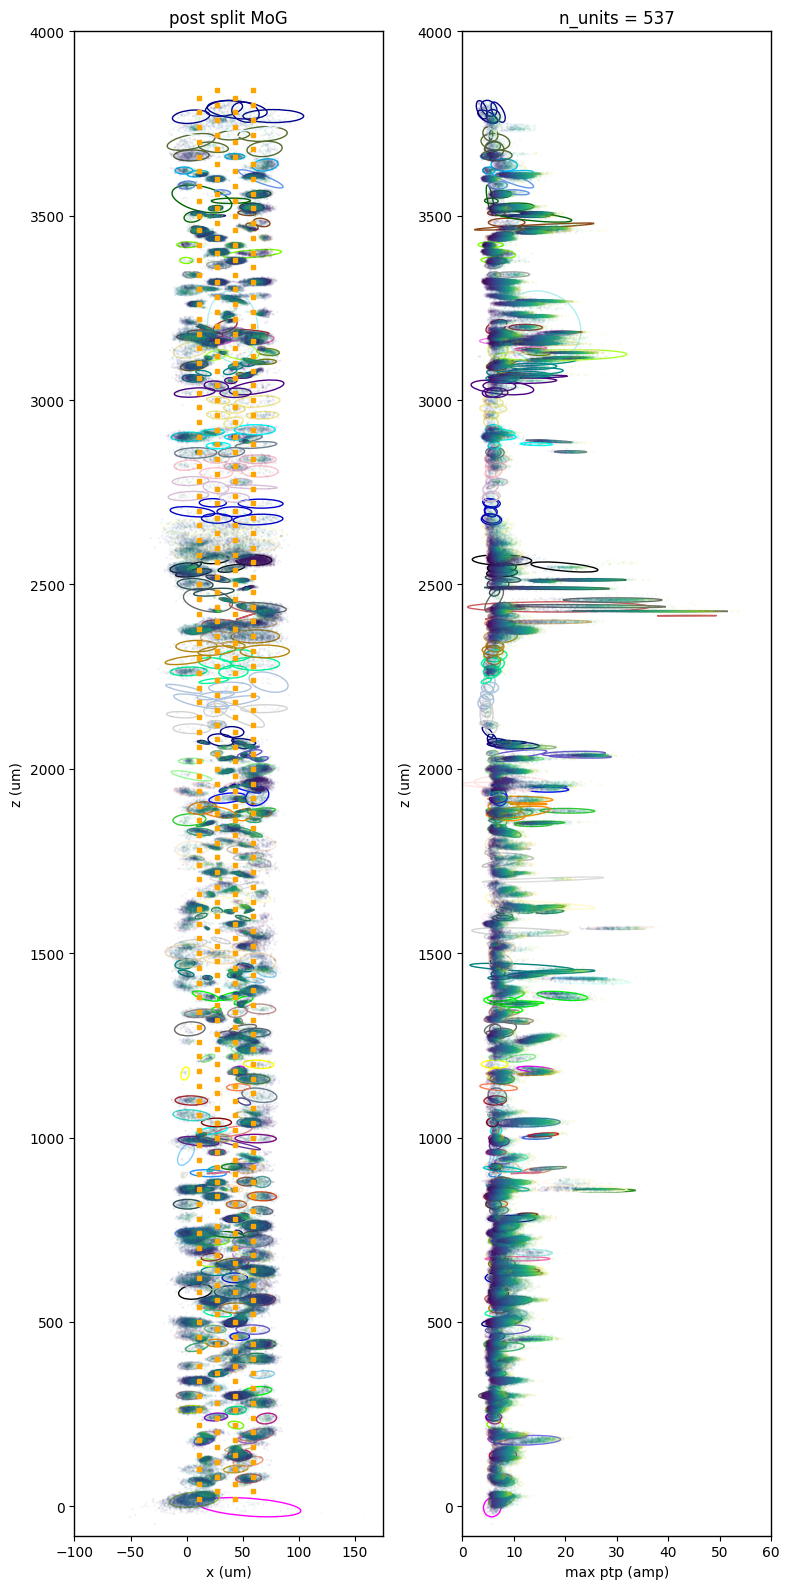

In [15]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [16]:
clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 537, 30)


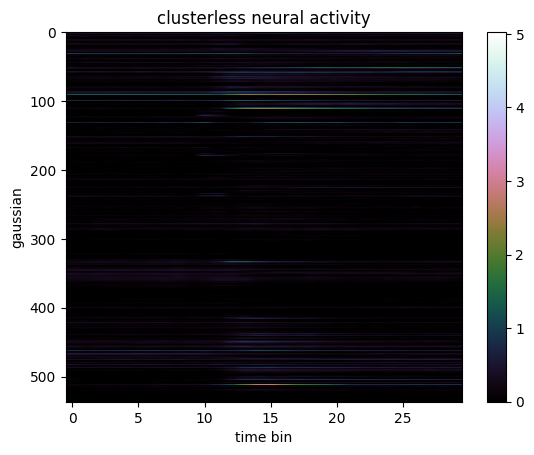

In [17]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [18]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=10, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=10, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 0.992
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 1.000 auc: 1.000
choice fold 5 test accuracy: 0.913 auc: 0.992
choice fold 6 test accuracy: 0.957 auc: 1.000
choice fold 7 test accuracy: 0.913 auc: 0.967
choice fold 8 test accuracy: 0.957 auc: 0.976
choice fold 9 test accuracy: 0.913 auc: 0.992
choice fold 10 test accuracy: 0.957 auc: 1.000
choice mean of 10-fold cv accuracy: 0.957 auc: 0.992
choice sd of 10-fold cv accuracy: 0.034 auc: 0.011
stimulus fold 1 test accuracy: 0.391 auc: 0.811
stimulus fold 2 test accuracy: 0.304 auc: 0.740
stimulus fold 3 test accuracy: 0.565 auc: 0.871
stimulus fold 4 test accuracy: 0.522 auc: 0.875
stimulus fold 5 test accuracy: 0.435 auc: 0.898
stimulus fold 6 test accuracy: 0.478 auc: 0.813
stimulus fold 7 test accuracy: 0.478 auc: 0.844
stimulus fold 8 test accuracy: 0.435 auc: 0.860
stimulus fold 9 test accuracy: 0.391 auc: 0.872
sti

In [20]:
del post_split_gmm
del spike_labels
del spike_probs

initialize MoG by max-chan partition

In [21]:
init_by_max_chan_gmm = GaussianMixture(n_components=len(sub_means), 
                                 means_init=sub_means,
                                 covariance_type='full',
                                 verbose=1,
                                 verbose_interval=1
                                 )
init_by_max_chan_gmm.fit(spike_features)

Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
  Iteration 20
  Iteration 21
  Iteration 22
  Iteration 23
  Iteration 24
  Iteration 25
  Iteration 26
  Iteration 27
Initialization converged: True


GaussianMixture(means_init=array([[  45.42013536,    3.96817412,    6.01890125],
       [   7.85155555,   19.02098131,    7.42402752],
       [  18.01024962,   32.34638496,    7.19200426],
       ...,
       [  41.33945278, 3777.71373477,    4.56245894],
       [  43.14942659, 3766.45199361,    4.87338571],
       [  43.71711212, 3768.33899407,    5.01498668]]),
                n_components=547, verbose=1, verbose_interval=1)

In [24]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(i*offset, (i+1)*offset)
    spike_labels.extend(init_by_max_chan_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(init_by_max_chan_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

0 100000
100000 200000
200000 300000
300000 400000
400000 500000


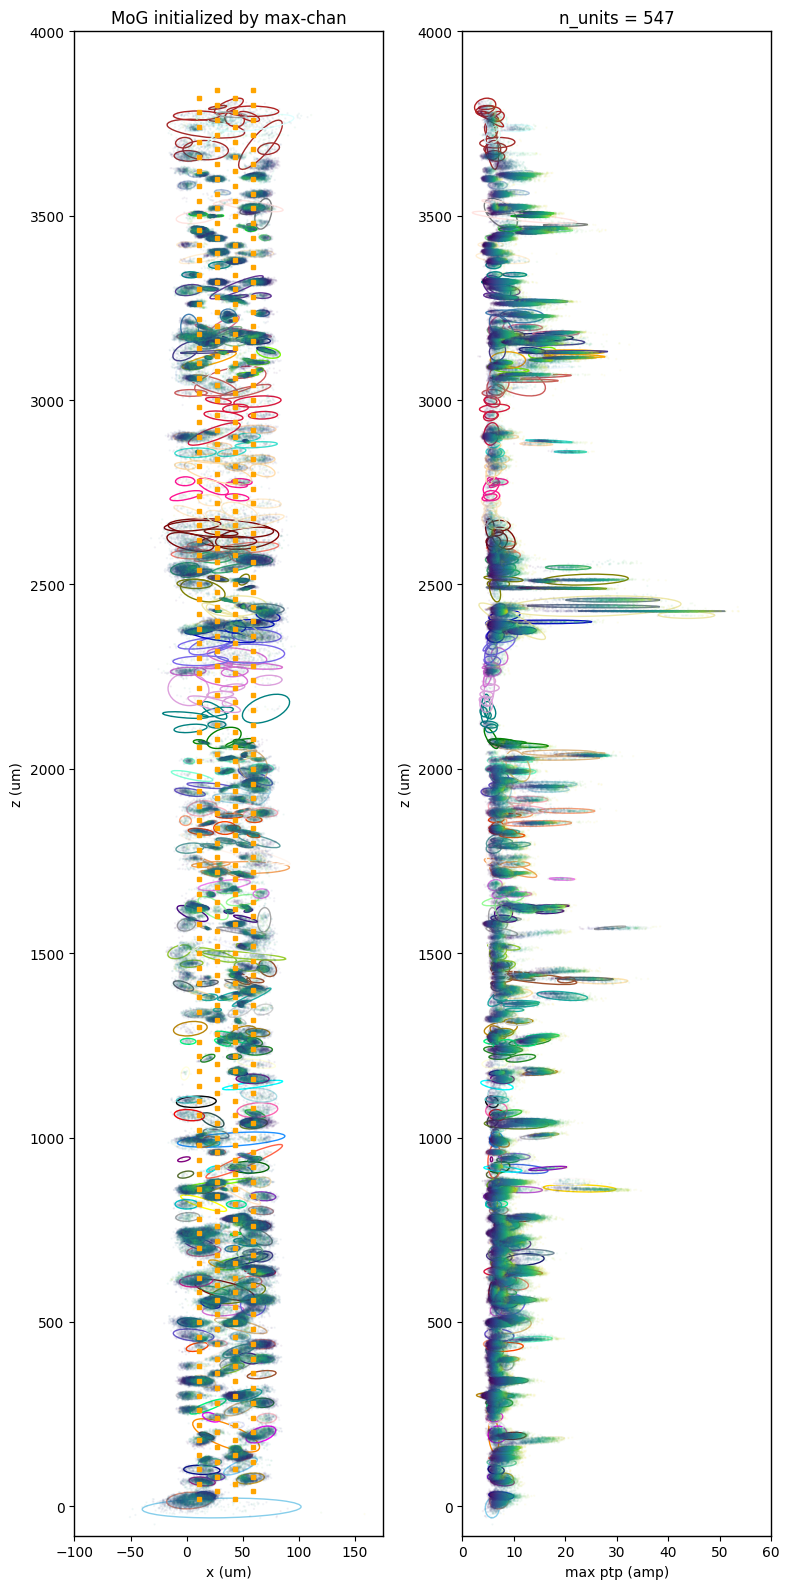

In [25]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='MoG initialized by max-chan'
)

In [26]:
clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 547, 30)


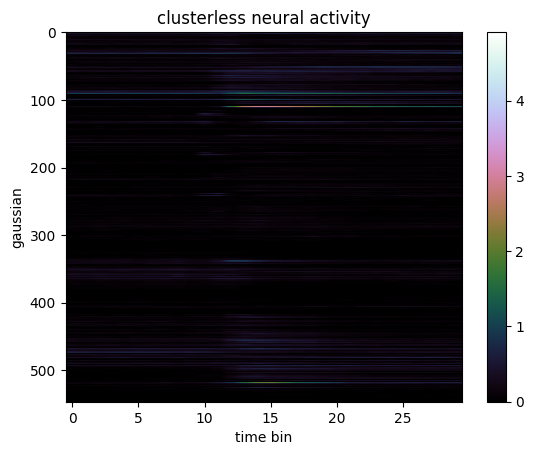

In [27]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [28]:
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=10, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=10, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.992
choice fold 2 test accuracy: 0.957 auc: 1.000
choice fold 3 test accuracy: 0.957 auc: 1.000
choice fold 4 test accuracy: 1.000 auc: 1.000
choice fold 5 test accuracy: 0.957 auc: 0.983
choice fold 6 test accuracy: 0.957 auc: 1.000
choice fold 7 test accuracy: 0.913 auc: 0.958
choice fold 8 test accuracy: 0.957 auc: 0.984
choice fold 9 test accuracy: 0.913 auc: 1.000
choice fold 10 test accuracy: 0.957 auc: 1.000
choice mean of 10-fold cv accuracy: 0.948 auc: 0.992
choice sd of 10-fold cv accuracy: 0.026 auc: 0.013
stimulus fold 1 test accuracy: 0.261 auc: 0.802
stimulus fold 2 test accuracy: 0.261 auc: 0.752
stimulus fold 3 test accuracy: 0.565 auc: 0.862
stimulus fold 4 test accuracy: 0.522 auc: 0.867
stimulus fold 5 test accuracy: 0.435 auc: 0.916
stimulus fold 6 test accuracy: 0.478 auc: 0.812
stimulus fold 7 test accuracy: 0.478 auc: 0.851
stimulus fold 8 test accuracy: 0.391 auc: 0.851
stimulus fold 9 test accuracy: 0.391 auc: 0.874
sti

In [29]:
del init_by_max_chan_gmm
del spike_labels
del spike_probs